<a href="https://colab.research.google.com/github/Badisj/Recurrent-Neural-Nets-NLP/blob/main/NLP_text_classif_and_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text classification using Neural Networks

The goal of this notebook is to use Neural Networks for text classification.

In this notebook, we will:
- Train a shallow model with learning embeddings
- Download pre-trained embeddings from Glove
- Use these pre-trained embeddings

However keep in mind:
- Deep Learning can be better on text classification that simpler ML techniques, but only on very large datasets and well designed/tuned models.
- We won't be using the most efficient (in terms of computing) techniques, as Keras is good for prototyping but rather inefficient for training small embedding models on text.
- The following projects can replicate similar word embedding models much more efficiently: [word2vec](https://github.com/dav/word2vec) and [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)   (self-supervised learning only), [fastText](https://github.com/facebookresearch/fastText) (both supervised and self-supervised learning), [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki) (supervised learning).
- Plain shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinomial Naive Bayes is often competitive in small to medium datasets.

## The BBC topic classification dataset

The BBC provides some benchmark topic classification datasets in English at: http://mlg.ucd.ie/datasets/bbc.html.

The raw text (encoded with the latin-1 character encoding) of the news can be downloaded as a ZIP archive:

In [62]:
import os
import os.path as op
import zipfile
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve


BBC_DATASET_URL = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip"
zip_filename = BBC_DATASET_URL.rsplit('/', 1)[1]
BBC_DATASET_FOLDER = 'bbc'
if not op.exists(zip_filename):
    print("Downloading %s to %s..." % (BBC_DATASET_URL, zip_filename))
    urlretrieve(BBC_DATASET_URL, zip_filename)

if not op.exists(BBC_DATASET_FOLDER):
    with zipfile.ZipFile(zip_filename, 'r') as f:
        print("Extracting contents of %s..." % zip_filename)
        f.extractall('.')

Each of the five folders contains text files from one of the five topics:

In [63]:
target_names = sorted([folder for folder in os.listdir(BBC_DATASET_FOLDER)
                       if op.isdir(op.join(BBC_DATASET_FOLDER, folder))])
target_names

['business', 'entertainment', 'politics', 'sport', 'tech']

Let's randomly partition the text files in a training and test set while recording the target category of each file as an integer:

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split

targets, filenames = [], []
for target, folder in enumerate(target_names):
    class_path = op.join(BBC_DATASET_FOLDER, folder)
    for item in sorted(os.listdir(class_path)):
        filenames.append(op.join(class_path, item))
        targets.append(target)

targets_train, targets_test, filenames_train, filenames_test = train_test_split(
    targets, filenames, test_size = 200)

In [65]:
len(targets_train), len(filenames_train)

(2025, 2025)

In [66]:
len(targets_test), len(filenames_test)

(200, 200)

Let's check that text of some document have been loaded correctly:

In [67]:
idx = 234

with open(filenames_train[idx], 'rb') as f:
      print(target_names[targets_train[idx]], ':')
      print()
      print(f.read().decode('latin-1')[:500] + '...')

sport :

Scotland v Italy (Sat)

Murrayfield, Edinburgh

Saturday, 26 February

1400 GMT

BBC1, Five Live and this website

Victory for the Azzurri in Rome last year saw Scotland end their campaign without a victory. And the pressure is on Scotland coach Matt Williams as he seeks a first Six Nations victory at the eighth attempt. Italy have lost both their opening games at home to Ireland and Wales, but travel to Edinburgh with high hopes.

Their coach John Kirwan has warned his side they must eradicate ...


In [68]:
texts_train = [open(fn,'rb').read().decode('latin-1') for fn in filenames_train]
texts_test = [open(fn,'rb').read().decode('latin-1') for fn in filenames_test]

# A first baseline model
For simple topic classification problems, one should always try a simple method first. In this case a good baseline is extracting TF-IDF normalized bag of bi-grams features and then use a simple linear classifier such as logistic regression.
It's a very efficient method and should give us a strong baseline to compare our deep learning method against.

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

text_classifier = make_pipeline(
                      TfidfVectorizer(max_df = .8, min_df = 3, ngram_range = (1,2)),
                      LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
)

In [70]:
%time _ = text_classifier.fit(texts_train, targets_train)

CPU times: user 7.86 s, sys: 4.98 s, total: 12.8 s
Wall time: 8.35 s


In [71]:
text_classifier.score(texts_test, targets_test)

0.97

Very few classification errors on 200 test documents for a model fit in less than 10s. It's quite unlikely that we can significantly beat that baseline with a more complex deep learning based model. However let's try to reach a comparable level of accuracy with Embeddings-based models just for teaching purpose.

### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`)
- we convert the output classes as 1-hot encodings

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer

MOST_FREQUENT = 20000
tokenizer = Tokenizer(num_words = MOST_FREQUENT)
tokenizer.fit_on_texts(texts_train)

sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index

Tokenized sequences are converted to list of token ids (with an integer code):

In [73]:
sequences_train[0][:5]

[10660, 19698, 19699, 3, 1142]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [74]:
index_to_word = dict((i,w) for w,i in word_index.items())

In [75]:
" ".join([index_to_word[i] for i in sequences_train[0]])

"teens 'know little' of politics teenagers questioned for a survey have shown little interest in politics and have little knowledge only a quarter of 14 16 year olds knew that labour was the government the tories were the official opposition and the lib dems were the third party almost all could identify tony blair but only one in six knew who michael howard was and just one in 10 recognised charles kennedy the icm survey interviewed 110 pupils for education watchdog ofsted nearly half those pupils polled said it was not important for them to know more about what the political parties stand for and 4 of those questioned thought the conservatives were in power while 2 of them believed the lib dems were the survey also looked at issues of nationality it found the union flag and fish and chips topped the list of symbols and foods associated with being british many of the pupils also looked on themselves as english scottish or welsh rather than british while the notion of being european ha

Let's display the tokenized items.

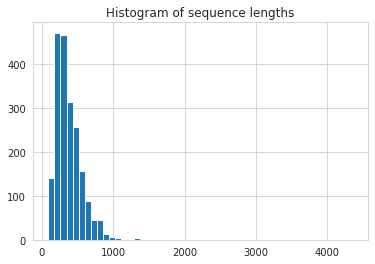

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

length_sequences = [len(seq) for seq in sequences_train]
plt.hist(length_sequences, bins = 50)
plt.title('Histogram of sequence lengths');

We truncate and pad the sequences to 1000 words max

In [77]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 1000
x_train = pad_sequences(maxlen = max_length, sequences = sequences_train)
x_test = pad_sequences(maxlen = max_length, sequences = sequences_test)

In [78]:
from tensorflow.keras.utils import to_categorical 

y_train = to_categorical(targets_train)
y_test = to_categorical(targets_test)

### A simple supervised CBOW model in Keras

The following computes a very simple model, as described in [fastText](https://github.com/facebookresearch/fastText):


- Build an embedding layer mapping each word to a vector representation
- Compute the vector representation of all words in each sequence and average them
- Add a dense layer to output 20 classes (+ softmax)

In [79]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM 
from tensorflow.keras.layers import GlobalAveragePooling1D, Input
from tensorflow.keras.optimizers import Adam

In [80]:
emb_size = 50
n_classes = len(target_names)

inputs = Input(shape = (max_length,))
embedding = Embedding(input_dim = MOST_FREQUENT, output_dim = emb_size)(inputs)
avgpool = GlobalAveragePooling1D()(embedding)
predictions = Dense(units = n_classes, activation = 'softmax')(avgpool)

model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = 'categorical_crossentropy',
              metrics = ['Accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 1000)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 255       
Total params: 1,000,255
Trainable params: 1,000,255
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.fit(x_train, y_train, batch_size = 32, 
          epochs = 10, validation_split = 0.1)

Epoch 1/10
57/57 [==============================] - 2s 23ms/step - loss: 1.4084 - Accuracy: 0.4665 - val_loss: 1.0473 - val_Accuracy: 0.7734
Epoch 2/10
57/57 [==============================] - 1s 21ms/step - loss: 0.6674 - Accuracy: 0.9061 - val_loss: 0.4436 - val_Accuracy: 0.9360
Epoch 3/10
57/57 [==============================] - 1s 20ms/step - loss: 0.2337 - Accuracy: 0.9824 - val_loss: 0.2696 - val_Accuracy: 0.9655
Epoch 4/10
57/57 [==============================] - 1s 19ms/step - loss: 0.1089 - Accuracy: 0.9934 - val_loss: 0.2070 - val_Accuracy: 0.9704
Epoch 5/10
57/57 [==============================] - 1s 20ms/step - loss: 0.0605 - Accuracy: 0.9967 - val_loss: 0.1865 - val_Accuracy: 0.9704
Epoch 6/10
57/57 [==============================] - 1s 21ms/step - loss: 0.0383 - Accuracy: 0.9995 - val_loss: 0.1709 - val_Accuracy: 0.9704
Epoch 7/10
57/57 [==============================] - 1s 20ms/step - loss: 0.0257 - Accuracy: 1.0000 - val_loss: 0.1694 - val_Accuracy: 0.9704
Epoch 8/10
57

In [82]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.1229 - Accuracy: 0.9550


[0.12291813641786575, 0.9549999833106995]

### Building more complex models

- From the previous template, we build more complex models using:
  - **1d convolution and 1d maxpooling**. Note that we will still need a GloabalAveragePooling or Flatten after the convolutions as the final `Dense` layer expects a fixed size input;
  - **Recurrent neural networks through LSTM** (we will need to **reduce sequence length before using the LSTM layer**).

- We may try different architectures with:
  - more intermediate layers, combination of dense, conv, recurrent
  - different recurrent (GRU, RNN)
  - bidirectional LSTMs

**Note**: The goal is to build working models rather than getting better test accuracy as this task is already very well solved by the simple model.  Build your model, and verify that they converge to OK results.

In [83]:
max_length = 500

x_train = pad_sequences(maxlen = max_length, sequences = sequences_train)
x_test = pad_sequences(maxlen = max_length, sequences = sequences_test)

y_train = to_categorical(targets_train)
y_test = to_categorical(targets_test)

In [84]:
Recc_units = 16

inputs = Input(shape = (max_length,))
embedding = Embedding(input_dim = MOST_FREQUENT, output_dim = emb_size)(inputs)

recurrent = LSTM(units = Recc_units )(embedding)
predictions = Dense(units = n_classes, activation = 'softmax')(recurrent)

model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = 'categorical_crossentropy',
              metrics = ['Accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 500, 50)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                4288      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 85        
Total params: 1,004,373
Trainable params: 1,004,373
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.fit(x_train, y_train, batch_size = 32, 
          epochs = 10, validation_split = 0.1)

Epoch 1/10
57/57 [==============================] - 15s 227ms/step - loss: 1.2471 - Accuracy: 0.4748 - val_loss: 0.8477 - val_Accuracy: 0.6798
Epoch 2/10
57/57 [==============================] - 13s 221ms/step - loss: 0.4062 - Accuracy: 0.8930 - val_loss: 0.7021 - val_Accuracy: 0.7783
Epoch 3/10
57/57 [==============================] - 17s 300ms/step - loss: 0.1184 - Accuracy: 0.9698 - val_loss: 0.8230 - val_Accuracy: 0.7685
Epoch 4/10
57/57 [==============================] - 13s 234ms/step - loss: 0.0354 - Accuracy: 0.9912 - val_loss: 0.7113 - val_Accuracy: 0.8079
Epoch 5/10
57/57 [==============================] - 16s 276ms/step - loss: 0.0083 - Accuracy: 0.9989 - val_loss: 0.8797 - val_Accuracy: 0.7635
Epoch 6/10
57/57 [==============================] - 13s 233ms/step - loss: 0.0217 - Accuracy: 0.9951 - val_loss: 0.9305 - val_Accuracy: 0.7488
Epoch 7/10
57/57 [==============================] - 13s 220ms/step - loss: 0.0067 - Accuracy: 0.9989 - val_loss: 1.0232 - val_Accuracy: 0.7586

In [86]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 34ms/step - loss: 0.9842 - Accuracy: 0.7750


[0.9841587543487549, 0.7749999761581421]


### Add more Recurrent units

In [87]:
Recc_units = 32

inputs = Input(shape = (max_length,))
embedding = Embedding(input_dim = MOST_FREQUENT, output_dim = emb_size)(inputs)

recurrent = LSTM(units = Recc_units)(embedding)

predictions = Dense(units = n_classes, activation = 'softmax')(recurrent)

model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['Accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 500, 50)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 1,010,789
Trainable params: 1,010,789
Non-trainable params: 0
_________________________________________________________________


In [88]:
model.fit(x_train, y_train, batch_size = 32, 
          epochs = 10, validation_split = 0.1)

Epoch 1/10
57/57 [==============================] - 72s 264ms/step - loss: 1.5936 - Accuracy: 0.2640 - val_loss: 1.5505 - val_Accuracy: 0.2512
Epoch 2/10
57/57 [==============================] - 14s 250ms/step - loss: 1.2154 - Accuracy: 0.5604 - val_loss: 0.9789 - val_Accuracy: 0.6108
Epoch 3/10
57/57 [==============================] - 14s 252ms/step - loss: 0.8429 - Accuracy: 0.7058 - val_loss: 0.8753 - val_Accuracy: 0.6749
Epoch 4/10
57/57 [==============================] - 16s 280ms/step - loss: 0.5012 - Accuracy: 0.9083 - val_loss: 0.6433 - val_Accuracy: 0.7980
Epoch 5/10
57/57 [==============================] - 15s 256ms/step - loss: 0.2781 - Accuracy: 0.9605 - val_loss: 0.5364 - val_Accuracy: 0.8522
Epoch 6/10
57/57 [==============================] - 14s 252ms/step - loss: 0.1220 - Accuracy: 0.9907 - val_loss: 0.4099 - val_Accuracy: 0.8966
Epoch 7/10
57/57 [==============================] - 15s 256ms/step - loss: 0.0616 - Accuracy: 0.9945 - val_loss: 0.3498 - val_Accuracy: 0.9015

In [89]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 46ms/step - loss: 1.3778 - Accuracy: 0.6450


[1.3777638673782349, 0.6449999809265137]

### Loading pre-trained embeddings

The file `glove100K.100d.txt` is an extract of [Glove](http://nlp.stanford.edu/projects/glove/) Vectors, that were trained on english Wikipedia 2014 + Gigaword 5 (6B tokens).

We extracted the `100 000` most frequent words. They have a dimension of `100`

In [90]:
# Get pretrained Glove Word2Vec
URL_REPRESENTATIONS = "https://github.com/Badisj/Recurrent-Neural-Nets-NLP/releases/download/v1.0/glove100K.100d.txt.zip"
ZIP_REPRESENTATIONS = "glove100k.100d.zip"
FILE_REPRESENTATIONS = "glove100K.100d.txt"

if not op.exists(ZIP_REPRESENTATIONS):
    print('Downloading from %s to %s...' % (URL_REPRESENTATIONS, ZIP_REPRESENTATIONS))
    urlretrieve(URL_REPRESENTATIONS, './' + ZIP_REPRESENTATIONS)
    
if not op.exists(FILE_REPRESENTATIONS):
    print("extracting %s..." % ZIP_REPRESENTATIONS)
    myzip = zipfile.ZipFile(ZIP_REPRESENTATIONS)
    myzip.extractall()

In [91]:
embeddings_index = {}
embeddings_vectors = []
with open('glove100K.100d.txt', 'rb') as f:
    word_idx = 0
    for line in f:
        values = line.decode('utf-8').split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = word_idx
        embeddings_vectors.append(vector)
        word_idx = word_idx + 1

inv_index = {v: k for k, v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

found 100000 different words in the file


In [92]:
# Stack all embeddings in a large numpy array
glove_embeddings = np.vstack(embeddings_vectors)
glove_norms = np.linalg.norm(glove_embeddings, axis=-1, keepdims=True)
glove_embeddings_normed = glove_embeddings / glove_norms
print(glove_embeddings.shape)

(100000, 100)


In [93]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings[idx]

    
def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings_normed[idx]

In [94]:
get_emb("computer")

array([-0.16298   ,  0.30141   ,  0.57978   ,  0.066548  ,  0.45835   ,
       -0.15329   ,  0.43258   , -0.89215   ,  0.57747   ,  0.36375   ,
        0.56524   , -0.56281   ,  0.35659   , -0.36096   , -0.099662  ,
        0.52753   ,  0.38839   ,  0.96185   ,  0.18841   ,  0.30741   ,
       -0.87842   , -0.32442   ,  1.1202    ,  0.075126  ,  0.42661   ,
       -0.60651   , -0.13893   ,  0.047862  , -0.45158   ,  0.093723  ,
        0.17463   ,  1.0962    , -1.0044    ,  0.063889  ,  0.38002   ,
        0.21109   , -0.66247   , -0.40736   ,  0.89442   , -0.60974   ,
       -0.18577   , -0.19913   , -0.69226   , -0.31806   , -0.78565   ,
        0.23831   ,  0.12992   ,  0.087721  ,  0.43205   , -0.22662   ,
        0.31549   , -0.31748   , -0.0024632 ,  0.16615   ,  0.42358   ,
       -1.8087    , -0.36699   ,  0.23949   ,  2.5458    ,  0.36111   ,
        0.039486  ,  0.48607   , -0.36974   ,  0.057282  , -0.49317   ,
        0.22765   ,  0.79966   ,  0.21428   ,  0.69811   ,  1.12

### Get similar words to a query 

In [95]:
def get_similar(query, embedding_matrix, top = 10):
    emb_query = get_emb(query)
    dist = []
    for i in range(embedding_matrix.shape[0]):
        dist.append(np.linalg.norm(emb_query - embedding_matrix[i,:]))
    idx = np.argsort(np.array(dist))[1:top+1]
    
    return [inv_index[id] for id in idx]

In [96]:
get_similar('computer', glove_embeddings, top = 10)

['computers',
 'software',
 'technology',
 'hardware',
 'pc',
 'computing',
 'electronic',
 'laptop',
 'desktop',
 'internet']

### Displaying words with TSNE

In [97]:
from sklearn.manifold import TSNE

embedding_tsne = TSNE(n_components = 2, perplexity = 30).fit_transform(glove_embeddings_normed[:1000])

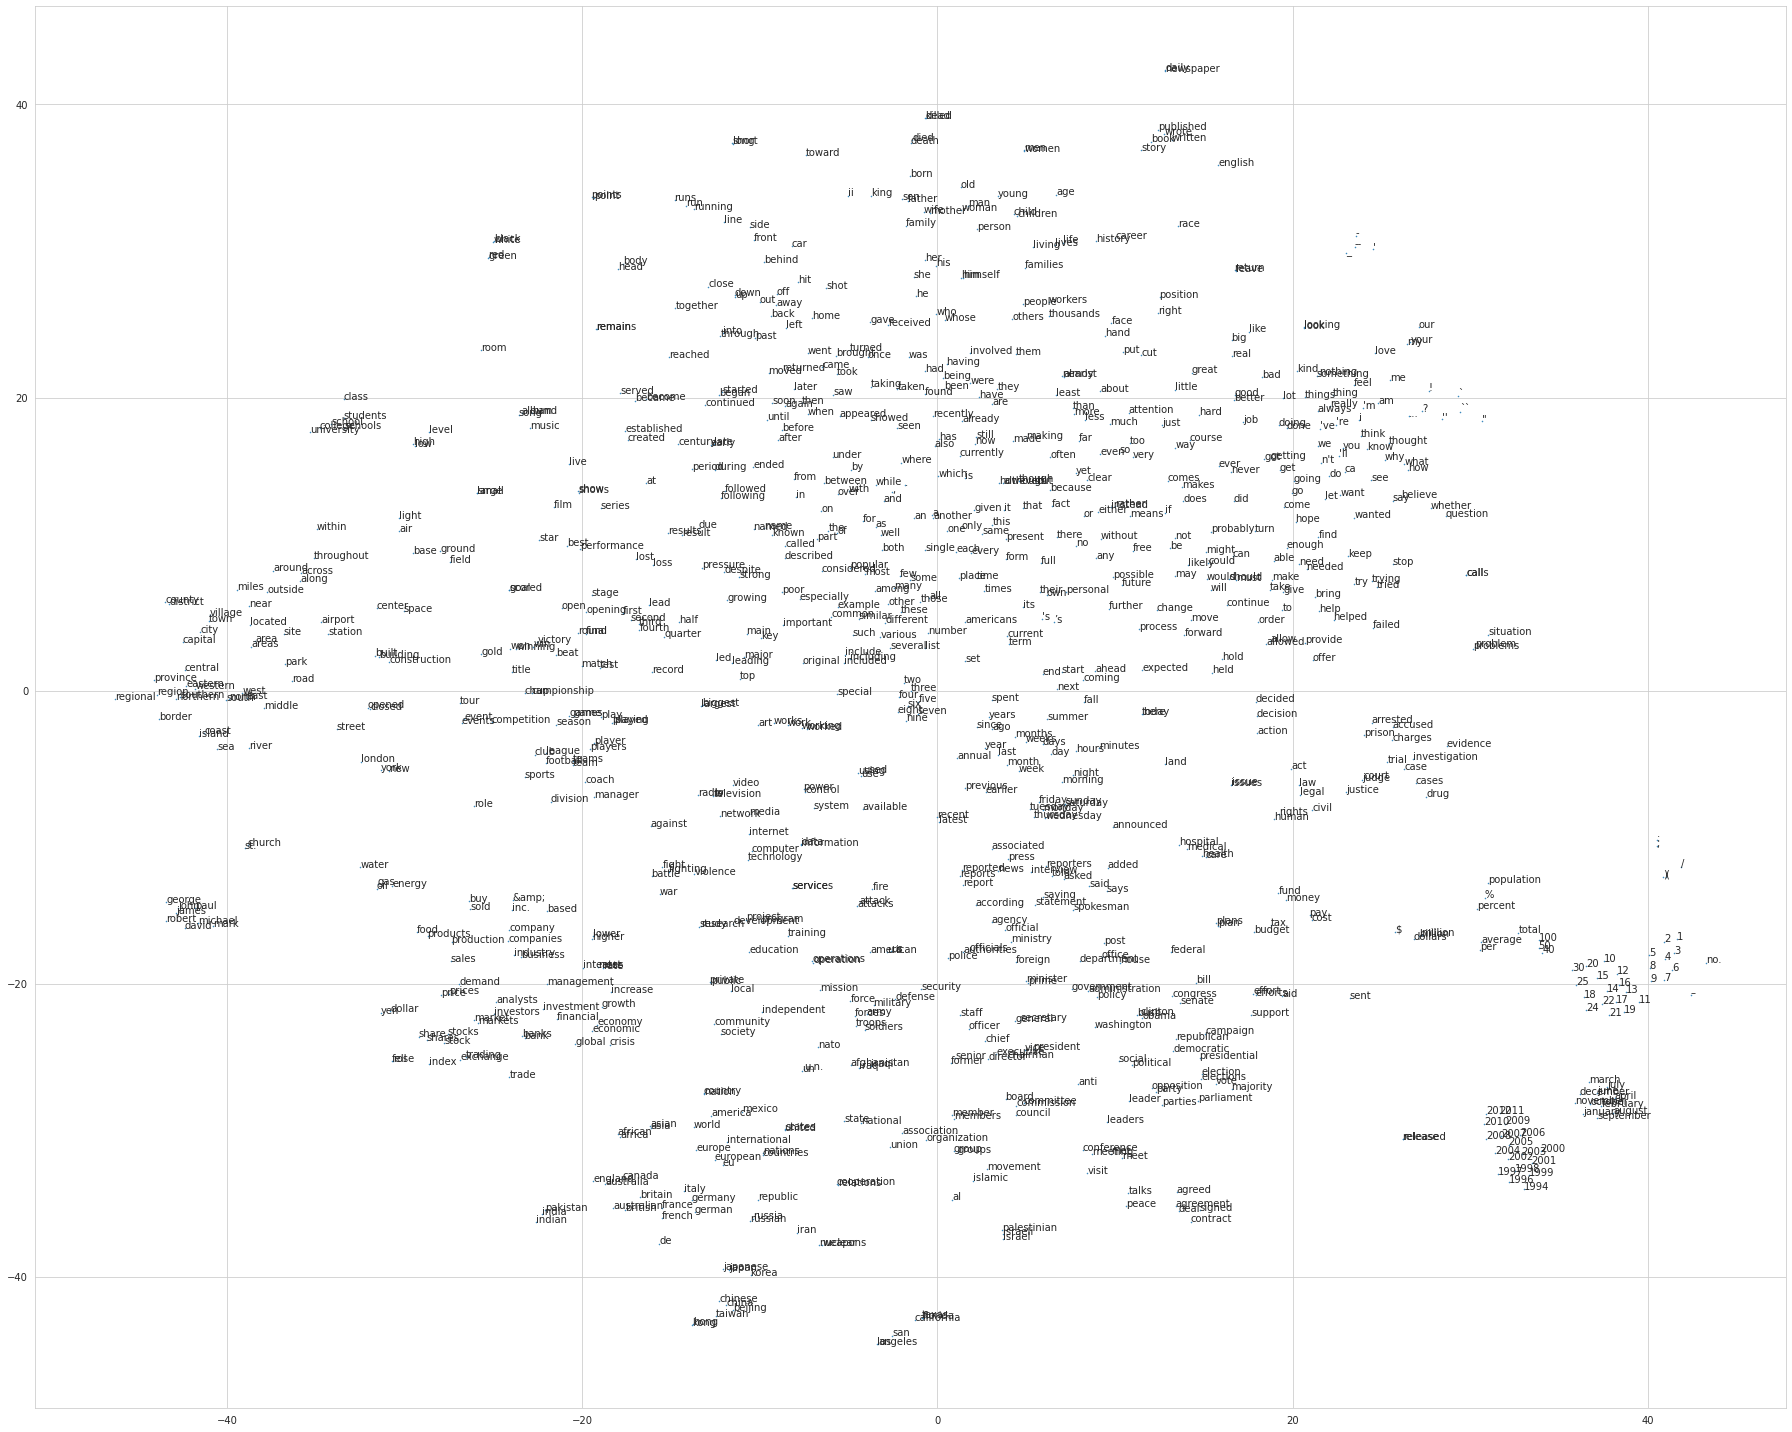

In [98]:
plt.figure(figsize=(25, 20))
axis = plt.gca()
np.set_printoptions(suppress=True)
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], marker = ".", s = 1)

for idx in range(1000):
    plt.annotate(inv_index[idx],
                 xy = (embedding_tsne[idx, 0], embedding_tsne[idx, 1]),
                 xytext = (0, 0), textcoords='offset points')
plt.tight_layout()
plt.savefig("tsne.png")
#plt.show()

### Using pre-trained embeddings in our model

We want to use these pre-trained embeddings for transfer learning. This process is rather similar than transfer learning in image recognition: the features learnt on words might help us bootstrap the learning process, and increase performance if we don't have enough training data.
- We initialize embedding matrix from the model with Glove embeddings:
 - take all unique words from our BBC news dataset to build a vocabulary (`MAX_NB_WORDS = 20000`), and look up their Glove embedding 
 - place the Glove embedding at the corresponding index in the matrix
 - if the word is not in the Glove vocabulary, we only place zeros in the matrix
- We may fix these embeddings or fine-tune them

In [99]:
EMBEDDING_DIM = 100

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MOST_FREQUENT, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MOST_FREQUENT:
        continue
    embedding_vector = get_emb(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 17322 words in the embedding matrix


Build a custom embedding layer

In [100]:
Custom_embedding = Embedding(input_dim = MOST_FREQUENT, output_dim = EMBEDDING_DIM,
                             weights = [embedding_matrix])

### A model with pre-trained Embeddings

Average word embeddings pre-trained with Glove / Word2Vec usually works surprisingly well. However, when averaging more than `10-15` words, the resulting vector becomes too noisy and classification performance is degraded.

In [101]:
recurrent = False

inputs = Input(shape = (max_length,))

embedding = Custom_embedding(inputs)
if recurrent == True:
    recurrent = LSTM(128)(embedding)
    predictions = Dense(units = n_classes, activation = 'softmax')(recurrent)
else:
    avgpool = GlobalAveragePooling1D()(embedding)
    predictions = Dense(units = n_classes, activation = 'softmax')(avgpool)

model = Model(inputs = inputs, outputs = predictions)

# No fine tuning
model.layers[1].trainable = False

model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = 'categorical_crossentropy',
              metrics = ['Accuracy'])
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 500, 100)          2000000   
_________________________________________________________________
global_average_pooling1d_7 ( (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 505       
Total params: 2,000,505
Trainable params: 505
Non-trainable params: 2,000,000
_________________________________________________________________


In [102]:
model.fit(x_train, y_train, 
          batch_size = 32, epochs = 10,
          validation_split = 0.1)

Epoch 1/10
57/57 [==============================] - 1s 8ms/step - loss: 1.2989 - Accuracy: 0.6636 - val_loss: 0.9943 - val_Accuracy: 0.8916
Epoch 2/10
57/57 [==============================] - 0s 5ms/step - loss: 0.8301 - Accuracy: 0.9094 - val_loss: 0.6858 - val_Accuracy: 0.9113
Epoch 3/10
57/57 [==============================] - 0s 6ms/step - loss: 0.6031 - Accuracy: 0.9325 - val_loss: 0.5426 - val_Accuracy: 0.9113
Epoch 4/10
57/57 [==============================] - 0s 6ms/step - loss: 0.4827 - Accuracy: 0.9308 - val_loss: 0.4501 - val_Accuracy: 0.9261
Epoch 5/10
57/57 [==============================] - 0s 6ms/step - loss: 0.4071 - Accuracy: 0.9374 - val_loss: 0.3904 - val_Accuracy: 0.9310
Epoch 6/10
57/57 [==============================] - 0s 6ms/step - loss: 0.3551 - Accuracy: 0.9440 - val_loss: 0.3553 - val_Accuracy: 0.9360
Epoch 7/10
57/57 [==============================] - 0s 5ms/step - loss: 0.3185 - Accuracy: 0.9429 - val_loss: 0.3244 - val_Accuracy: 0.9409
Epoch 8/10
57/57 [==

In [103]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 4ms/step - loss: 0.2602 - Accuracy: 0.9250


[0.26020267605781555, 0.925000011920929]

**To conclude**
- On this type of task, using pre-trained embeddings can degrade results as we train much less parameters and we average a large number pre-trained embeddings.

- Pre-trained embeddings followed by global averaging prevents overfitting but can also cause some underfitting.

- Using convolutions / LSTM should help counter the underfitting effect.

- It is also advisable to treat separately pre-trained embeddings and words out of vocabulary.

Pre-trained embeddings can be very useful when the training set is small and the individual text documents to classify are short: in this case there might be a single very important word in a test document that drives the label. If that word has never been seen in the training set but some synonyms were seen, the semantic similarity captured by the embedding will allow the model to generalized out of the restricted training set vocabulary.

We did not observe this effect here because the document are long enough so that guessing the topic can be done redundantly. Shortening the documents to make the task more difficult could possibly highlight this benefit.

## Going further

- Compare pre-trained embeddings vs specifically trained embeddings
- Train your own wordvectors in any language using [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
- Install fastText (Linux or macOS only, use the Linux VM if under Windows) and give it a try on the classification example in its repository.
- Today, the **state-of-the-art text classification** can be achieved by **transfer learning from a language model** instead of using traditional word embeddings. See for instance: [ULMFit, Fine-tuned Language Models for Text Classification](https://arxiv.org/abs/1801.06146), [ELMO](https://allennlp.org/elmo), [GPT](https://blog.openai.com/language-unsupervised/), [BERT](https://arxiv.org/abs/1810.04805), [GPT-2](https://github.com/openai/gpt-2).